In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.discriminant_analysis import StandardScaler
from captum.attr import IntegratedGradients
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm

In [203]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# For deterministic behavior in CUDA (if used)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [204]:
class CNN_1D(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x).squeeze(-1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

## Task 1: MCI vs. AD

In [183]:
def compute_metrics(y_true, y_pred,positive_class):
    """
    Computes sensitivity (recall), specificity for ONE selected class.
    y_true and y_pred must be 1-D numpy arrays.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Binary mask: positive_class vs all others
    pos = (y_true == positive_class)
    pred_pos = (y_pred == positive_class)

    # True positives, false negatives, true negatives, false positives
    TP = np.sum(pos & pred_pos)
    FN = np.sum(pos & (~pred_pos))
    TN = np.sum((~pos) & (~pred_pos))
    FP = np.sum((~pos) & pred_pos)

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    return sensitivity, specificity


def train_one_fold(model, train_loader, val_loader, y_train_all, epochs=50,device=device):
    model.to(device)
    # compute class weights based on training fold only
    classes = np.unique(y_train_all)
    cls_weights = compute_class_weight('balanced', classes=classes, y=y_train_all)
    cls_weights = torch.tensor(cls_weights, dtype=torch.float32, device=device)

    criterion = nn.CrossEntropyLoss(weight=cls_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_acc = 0
    best_state = None

    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # --- validation ---
        model.eval()
        val_loss_total = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                pred_labels = preds.argmax(dim=1)
                loss = criterion(preds, yb)
                val_loss_total += loss.item() * xb.size(0)
                correct += (pred_labels == yb).sum().item()
                total += len(yb)
        val_loss = val_loss_total / total
        val_acc = correct / total
        sensitivity, specificity = compute_metrics(yb.numpy(), pred_labels.numpy(), positive_class=1)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()
        
        best_matrix = {
            'val_acc': val_acc,
            'val_loss': val_loss,
            'sensitivity': sensitivity,
            'specificity': specificity
        }

    model.load_state_dict(best_state)
    return model, best_matrix

def cross_validate_cnn(X, y, k_folds=5, epochs=50, device=device):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_models = []
    fold_metrics = []

    for train_idx, val_idx in kf.split(X):
        X_train = torch.tensor(X[train_idx], dtype=torch.float32).unsqueeze(1).to(device)
        y_train = torch.tensor(y[train_idx], dtype=torch.long).to(device)
        X_val = torch.tensor(X[val_idx], dtype=torch.float32).unsqueeze(1).to(device)
        y_val = torch.tensor(y[val_idx], dtype=torch.long).to(device)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

        model = CNN_1D(num_classes=len(np.unique(y))).to(device)
        model, val_acc = train_one_fold(model, train_loader, val_loader, y[train_idx], epochs, device)

        fold_models.append(model)
        fold_metrics.append(val_acc)
        print(f"Fold Done (val acc = {val_acc['val_acc']:.3f}, val loss = {val_acc['val_loss']:.3f}, sensitivity = {val_acc['sensitivity']:.3f}, specificity = {val_acc['specificity']:.3f})")

    mean_val_acc = np.mean([m['val_acc'] for m in fold_metrics])
    mean_val_loss = np.mean([m['val_loss'] for m in fold_metrics])
    mean_sens = np.mean([m['sensitivity'] for m in fold_metrics])
    mean_spec = np.mean([m['specificity'] for m in fold_metrics])

    print(f"\n=== Cross-Validation Summary ({k_folds}-fold) ===")
    print(f"Mean Val Acc: {mean_val_acc:.3f}, Mean Loss: {mean_val_loss:.3f}, Mean Sensitivity: {mean_sens:.3f}, Mean Specificity: {mean_spec:.3f}")

    return fold_models

def compute_global_ig(fold_models, X, y, device=device):
    all_attr = []

    print("Computing Integrated Gradients across folds...")

    # loop over folds with tqdm
    for fold_i, model in enumerate(tqdm(fold_models, desc="Folds"), 1):

        model.eval().to(device)
        ig = IntegratedGradients(model)

        fold_attr = []

        # tqdm over samples
        for i in tqdm(range(len(X)), desc=f"Fold {fold_i} samples", leave=False):
            inp = torch.tensor(X[i:i+1], dtype=torch.float32).unsqueeze(1).to(device)

            attr, _ = ig.attribute(
                inp,
                target=int(y[i]),
                return_convergence_delta=True
            )

            fold_attr.append(attr.squeeze().detach().cpu().numpy())

        fold_attr = np.vstack(fold_attr)  # (N, G)
        all_attr.append(np.mean(np.abs(fold_attr), axis=0))

    # Final averaged IG score across folds
    return np.mean(np.vstack(all_attr), axis=0)


def find_optimal_k(ig_scores,k):
    sorted_scores = np.sort(ig_scores)[::-1]

    # compute curvature (second finite difference)
    curvature = np.diff(sorted_scores, n=2)

    # elbow at max curvature
    elbow_k = np.argmax(np.abs(curvature)) + 2   # +2 because of second diff

    # Plot elbow curve
    plt.figure(figsize=(6,4))
    plt.plot(sorted_scores, label="IG scores (sorted)")
    plt.axvline(k, linestyle="--", label=f"k={k}", color="r")
    plt.legend()
    plt.title("IG-Based Elbow Method for Gene Selection")
    plt.xlabel("Gene Rank")
    plt.ylabel("IG Score")
    plt.show()

    return elbow_k

def reduce_genes(X, ig_scores, k):
    top_idx = np.argsort(ig_scores)[::-1][:k]
    return X[:, top_idx], top_idx

def train_final_cnn_cv(X_reduced, y_np, epochs=20, k_folds=5, device=device):
    print("---- Final Cross-Validation on IG-Selected Genes ----")
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_models = []
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_reduced), 1):
        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=16)

        model = CNN_1D(num_classes=len(np.unique(y_np))).to(device)
        model, best_matrix = train_one_fold(model, train_loader, val_loader, y_train, epochs=epochs, device=device)

        print(f"Fold Done (val acc = {best_matrix['val_acc']:.3f}, val loss = {best_matrix['val_loss']:.3f}, sensitivity = {best_matrix['sensitivity']:.3f}, specificity = {best_matrix['specificity']:.3f})")

        fold_models.append(model)
        fold_metrics.append(best_matrix)

    # Average metrics across folds
    mean_val_acc = np.mean([m['val_acc'] for m in fold_metrics])
    mean_sens = np.mean([m['sensitivity'] for m in fold_metrics])
    mean_spec = np.mean([m['specificity'] for m in fold_metrics])

    print(f"\n=== Cross-Validation Summary ({k_folds}-fold) ===")
    print(f"Mean Val Acc: {mean_val_acc:.3f}, Mean Sensitivity: {mean_sens:.3f}, Mean Specificity: {mean_spec:.3f}")

    return fold_models


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_65674/1511652096.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_int = y.replace(label_map).astype(int).values   # numpy array


Training data shape: (116, 2000), Labels shape: (116,)
Classify:  (array([0, 1]), array([49, 67])) clases
Fold Done (val acc = 0.542, val loss = 0.796, sensitivity = 0.667, specificity = 1.000)
Fold Done (val acc = 0.391, val loss = 0.944, sensitivity = 1.000, specificity = 0.000)
Fold Done (val acc = 0.435, val loss = 0.802, sensitivity = 0.333, specificity = 0.500)
Fold Done (val acc = 0.565, val loss = 0.741, sensitivity = 0.000, specificity = 1.000)
Fold Done (val acc = 0.478, val loss = 0.743, sensitivity = 0.333, specificity = 1.000)

=== Cross-Validation Summary (5-fold) ===
Mean Val Acc: 0.482, Mean Loss: 0.805, Mean Sensitivity: 0.467, Mean Specificity: 0.700
Computing Integrated Gradients across folds...


Folds: 100%|██████████| 5/5 [07:48<00:00, 93.61s/it]


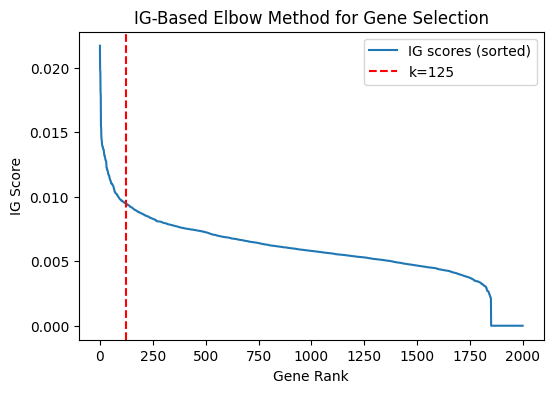

Optimal k (elbow method): 6
---- Final Cross-Validation on IG-Selected Genes ----
Fold Done (val acc = 0.750, val loss = 0.638, sensitivity = 0.833, specificity = 0.500)
Fold Done (val acc = 0.435, val loss = 1.104, sensitivity = 1.000, specificity = 0.500)
Fold Done (val acc = 0.565, val loss = 0.786, sensitivity = 0.667, specificity = 0.750)
Fold Done (val acc = 0.565, val loss = 0.815, sensitivity = 0.667, specificity = 1.000)
Fold Done (val acc = 0.652, val loss = 0.671, sensitivity = 1.000, specificity = 0.250)

=== Cross-Validation Summary (5-fold) ===
Mean Val Acc: 0.593, Mean Sensitivity: 0.833, Mean Specificity: 0.600


In [191]:
train_data = pd.read_csv('train_mi_data.csv', index_col=None)

# Separate features (genes) and labels
X_df = train_data.drop(columns=['sample', 'disease_state'])

label_map = {
    'S-MCI': 1,
    'P-MCI': 1,
    'AD': 0
}

y = train_data['disease_state']
y_int = y.replace(label_map).astype(int).values   # numpy array
X_np_raw = X_df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np_raw)         # already numpy
print(f"Training data shape: {X_scaled.shape}, Labels shape: {y_int.shape}")
X_np = X_scaled.astype(np.float32)     # safe conversion
y_np = y_int.astype(np.int64)
print(f"Classify:  {np.unique(y_np, return_counts=True)} clases")

# Step 1 — CV to train multiple CNNs
fold_models = cross_validate_cnn(X_np, y_np, k_folds=5, epochs=50)

# Step 2 — Compute global IG scores
ig_scores = compute_global_ig(fold_models, X_np, y_np)

# Step 3 — Automatic optimal k using IG-elbow
k_opt = find_optimal_k(ig_scores, 125)
print(f"Optimal k (elbow method): {k_opt}")

# Step 4 — Reduce dataset to top-k genes
X_reduced, selected_idx = reduce_genes(X_np, ig_scores, 125)

# Step 5 — Train final CNN on IG-selected genes
final_model = train_final_cnn_cv(X_reduced, y_np, epochs=50)


In [192]:
gene_cols = X_df.columns.tolist()

top_genes = [gene_cols[i] for i in selected_idx]
print(f"Top IG-selected genes: {len(top_genes)} \n {top_genes}")
sorted_ig = np.sort(ig_scores[selected_idx])[::-1]
top_k_task1 = pd.DataFrame({'gene_id': top_genes, 'ig_score': sorted_ig[:200]})

top_k_task1.to_csv('top_ig_genes_task1.csv', index=False)

Top IG-selected genes: 125 
 ['ENSG00000284631', 'ENSG00000179546', 'ENSG00000279076', 'ENSG00000183067', 'ENSG00000214026', 'ENSG00000164107', 'ENSG00000176988', 'ENSG00000188984', 'ENSG00000204595', 'ENSG00000196900', 'ENSG00000196620', 'ENSG00000094963', 'ENSG00000242498', 'ENSG00000164112', 'ENSG00000129864', 'ENSG00000280416', 'ENSG00000189171', 'ENSG00000125753', 'ENSG00000277150', 'ENSG00000175619', 'ENSG00000154646', 'ENSG00000172037', 'ENSG00000072041', 'ENSG00000211967', 'ENSG00000122145', 'ENSG00000169429', 'ENSG00000186470', 'ENSG00000094661', 'ENSG00000101680', 'ENSG00000259303', 'ENSG00000250506', 'ENSG00000147649', 'ENSG00000166363', 'ENSG00000178928', 'ENSG00000183054', 'ENSG00000074416', 'ENSG00000179344', 'ENSG00000141338', 'ENSG00000186340', 'ENSG00000101144', 'ENSG00000185220', 'ENSG00000146453', 'ENSG00000167264', 'ENSG00000185101', 'ENSG00000002746', 'ENSG00000175325', 'ENSG00000125734', 'ENSG00000137090', 'ENSG00000176125', 'ENSG00000166840', 'ENSG00000121207', '

### Evaluation

Test data shape: (41, 125), Labels shape: (41,)
Classify:  (array([0, 1]), array([21, 20])) clases
Test Accuracy: 0.3902439024390244
Sensitivity: 0.0
Specificity: 0.9999999997560975
Confusion Matrix:
 [[ 6 15]
 [10 10]]


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_65674/2965510078.py:70: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_int = y.replace(label_map).astype(int).values   # numpy array


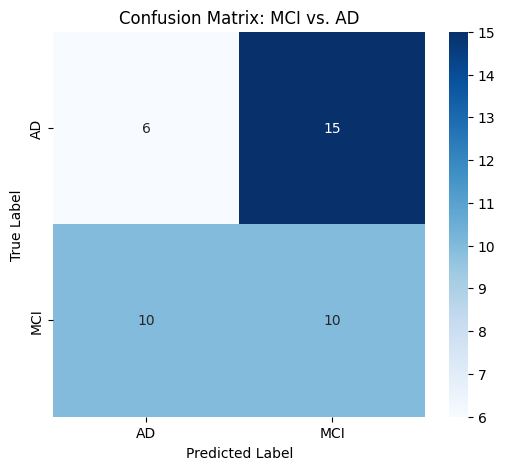

In [193]:
from sklearn.metrics import confusion_matrix, accuracy_score

def test_cnn(model, test_loader, device, positive_class=2):
    """
    Evaluates a trained CNN model on test data.

    Args:
        model: trained PyTorch model
        test_loader: DataLoader for test dataset
        device: 'cuda' or 'cpu'
        positive_class: int, class for sensitivity/specificity

    Returns:
        metrics: dict with accuracy, sensitivity, specificity, confusion matrix
        y_true: true labels (numpy)
        y_pred: predicted labels (numpy)
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Sensitivity & Specificity for the selected class
    pos_mask = (y_true == positive_class)
    pred_pos_mask = (y_pred == positive_class)

    TP = np.sum(pos_mask & pred_pos_mask)
    FN = np.sum(pos_mask & (~pred_pos_mask))
    TN = np.sum((~pos_mask) & (~pred_pos_mask))
    FP = np.sum((~pos_mask) & pred_pos_mask)

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    metrics = {
        "accuracy": acc,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm
    }

    return metrics, y_true, y_pred

# Load and preprocess test data
test_data = pd.read_csv('test_mi_data.csv', index_col=None)
X_df = test_data.drop(columns=['sample', 'disease_state'])
X_df = X_df[top_genes]  # select only IG-chosen genes
label_map = {
    'MCI':1,
    'AD': 0
}
y = test_data['disease_state']
y_int = y.replace(label_map).astype(int).values   # numpy array

X_np_raw = X_df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np_raw)         # already numpy
print(f"Test data shape: {X_scaled.shape}, Labels shape: {y_int.shape}")
X_test_np = X_scaled.astype(np.float32)     # safe conversion
y_test_np = y_int.astype(np.int64)
print(f"Classify:  {np.unique(y_test_np, return_counts=True)} clases")


# Assuming X_test_np, y_test_np are NumPy arrays
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Load best model
model = final_model[0]
model.to(device)

metrics, y_true, y_pred = test_cnn(model, test_loader, device, positive_class=2)

print("Test Accuracy:", metrics["accuracy"])
print("Sensitivity:", metrics["sensitivity"])
print("Specificity:", metrics["specificity"])
print("Confusion Matrix:\n", metrics["confusion_matrix"])

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(metrics["confusion_matrix"], annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"AD", f"MCI"],
            yticklabels=[f"AD", f"MCI"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: MCI vs. AD')
plt.show()


## Task 2: S-MCI vs P-MCI vs AD

In [212]:
def compute_metrics(y_true, y_pred, classes):
    """
    Returns overall accuracy, per-class sensitivity and specificity
    as dictionaries/matrix.
    """
    cm = confusion_matrix(y_true, y_pred, labels=classes)

    sens = {}  # sensitivity / recall per class
    spec = {}  # specificity per class

    for i, cls in enumerate(classes):
        TP = cm[i, i]
        FN = cm[i, :].sum() - TP
        FP = cm[:, i].sum() - TP
        TN = cm.sum() - (TP + FN + FP)

        sens[cls] = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec[cls] = TN / (TN + FP) if (TN + FP) > 0 else 0

    return  sens, spec


def train_one_fold(model, train_loader, val_loader, y_train_all, epochs=50, device=device):
    model.to(device)
    classes = np.unique(y_train_all)

    # class weights
    cls_weights = compute_class_weight('balanced', classes=classes, y=y_train_all)
    cls_weights = torch.tensor(cls_weights, dtype=torch.float32, device=device)

    criterion = nn.CrossEntropyLoss(weight=cls_weights)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    best_val_acc = 0
    best_state = None

    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            loss = criterion(model(xb), yb)
            loss.backward()
            optimizer.step()

        # --- VALIDATION ---
        model.eval()
        val_loss_total = 0
        correct = 0
        total = 0

        all_true = []
        all_pred = []

        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                pred_labels = preds.argmax(dim=1)

                loss = criterion(preds, yb)

                val_loss_total += loss.item() * xb.size(0)
                correct += (pred_labels == yb).sum().item()
                total += len(yb)

                all_true.append(yb.cpu().numpy())
                all_pred.append(pred_labels.cpu().numpy())

        # concatenate all validation predictions
        y_true_all = np.concatenate(all_true)
        y_pred_all = np.concatenate(all_pred)

        val_loss = val_loss_total / total
        val_acc = correct / total

        # compute 3-class metrics
        sensitivity, specificity = compute_metrics(
            y_true_all, 
            y_pred_all, 
            classes=classes
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = model.state_dict()

        best_matrix = {
            'val_acc': val_acc,
            'val_loss': val_loss,
            'sensitivity': sensitivity,
            'specificity': specificity
        }

    model.load_state_dict(best_state)
    return model, best_matrix


def cross_validate_cnn(X, y, k_folds=5, epochs=50, device=device):
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_models = []
    fold_metrics = []

    for train_idx, val_idx in kf.split(X):
        X_train = torch.tensor(X[train_idx], dtype=torch.float32).unsqueeze(1).to(device)
        y_train = torch.tensor(y[train_idx], dtype=torch.long).to(device)
        X_val = torch.tensor(X[val_idx], dtype=torch.float32).unsqueeze(1).to(device)
        y_val = torch.tensor(y[val_idx], dtype=torch.long).to(device)

        train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=16)

        model = CNN_1D(num_classes=len(np.unique(y))).to(device)
        model, metrics = train_one_fold(model, train_loader, val_loader, y[train_idx], epochs, device)

        # Convert dicts → numpy array for averaging
        sens_values = np.array(list(metrics["sensitivity"].values()))
        spec_values = np.array(list(metrics["specificity"].values()))

        metrics["mean_sensitivity"] = sens_values.mean()
        metrics["mean_specificity"] = spec_values.mean()

        fold_models.append(model)
        fold_metrics.append(metrics)

        print(f"Fold Done "
              f"(acc={metrics['val_acc']:.3f}, loss={metrics['val_loss']:.3f}, "
              f"spec={metrics['specificity']},"
              f"sens={metrics['sensitivity']},"
              f"mean_sens={metrics['mean_sensitivity']:.3f}, "
              f"mean_spec={metrics['mean_specificity']:.3f})")

    # Compute CV macro-means
    mean_val_acc = np.mean([m['val_acc'] for m in fold_metrics])
    mean_val_loss = np.mean([m['val_loss'] for m in fold_metrics])
    mean_sens = np.mean([m['mean_sensitivity'] for m in fold_metrics])
    mean_spec = np.mean([m['mean_specificity'] for m in fold_metrics])

    print(f"\n=== Cross-Validation Summary ({k_folds}-fold) ===")
    print(f"Mean Val Acc: {mean_val_acc:.3f}")
    print(f"Mean Loss: {mean_val_loss:.3f}")
    print(f"Mean Sensitivity: {mean_sens:.3f}")
    print(f"Mean Specificity: {mean_spec:.3f}")

    return fold_models


def compute_global_ig(fold_models, X, y, device=device):
    all_attr = []

    print("Computing Integrated Gradients across folds...")

    # loop over folds with tqdm
    for fold_i, model in enumerate(tqdm(fold_models, desc="Folds"), 1):

        model.eval().to(device)
        ig = IntegratedGradients(model)

        fold_attr = []

        # tqdm over samples
        for i in tqdm(range(len(X)), desc=f"Fold {fold_i} samples", leave=False):
            inp = torch.tensor(X[i:i+1], dtype=torch.float32).unsqueeze(1).to(device)

            attr, _ = ig.attribute(
                inp,
                target=int(y[i]),
                return_convergence_delta=True
            )

            fold_attr.append(attr.squeeze().detach().cpu().numpy())

        fold_attr = np.vstack(fold_attr)  # (N, G)
        all_attr.append(np.mean(np.abs(fold_attr), axis=0))

    # Final averaged IG score across folds
    return np.mean(np.vstack(all_attr), axis=0)


def find_optimal_k(ig_scores):
    sorted_scores = np.sort(ig_scores)[::-1]

    # compute curvature (second finite difference)
    curvature = np.diff(sorted_scores, n=2)

    # elbow at max curvature
    elbow_k = np.argmax(np.abs(curvature)) + 2   # +2 because of second diff

    # Plot elbow curve
    plt.figure(figsize=(6,4))
    plt.plot(sorted_scores, label="IG scores (sorted)")
    plt.axvline(100, linestyle="--", label=f"k=100", color="r")
    plt.legend()
    plt.title("IG-Based Elbow Method for Gene Selection")
    plt.xlabel("Gene Rank")
    plt.ylabel("IG Score")
    plt.show()

    return elbow_k

def reduce_genes(X, ig_scores, k):
    top_idx = np.argsort(ig_scores)[::-1][:k]
    return X[:, top_idx], top_idx

def train_final_cnn_cv(X_reduced, y_np, epochs=20, k_folds=5, device=device):
    print("---- Final Cross-Validation on IG-Selected Genes ----")
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_models = []
    fold_metrics = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_reduced), 1):
        X_train, X_val = X_reduced[train_idx], X_reduced[val_idx]
        y_train, y_val = y_np[train_idx], y_np[val_idx]

        X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
        y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
        X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)
        y_val_tensor = torch.tensor(y_val, dtype=torch.long).to(device)

        train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=16, shuffle=True)
        val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=16)

        model = CNN_1D(num_classes=len(np.unique(y_np))).to(device)
        model, best_matrix = train_one_fold(model, train_loader, val_loader, y_train, epochs=epochs, device=device)

        # Convert dicts → numpy array for averaging
        sens_values = np.array(list(best_matrix["sensitivity"].values()))
        spec_values = np.array(list(best_matrix["specificity"].values()))

        best_matrix["mean_sensitivity"] = sens_values.mean()
        best_matrix["mean_specificity"] = spec_values.mean()

        fold_models.append(model)
        fold_metrics.append(best_matrix)

        print(f"Fold Done "
              f"(acc={best_matrix['val_acc']:.3f},"
              f"spec={best_matrix['specificity']},"
              f"sens={best_matrix['sensitivity']},"
              f"mean_sens={best_matrix['mean_sensitivity']:.3f}, "
              f"mean_spec={best_matrix['mean_specificity']:.3f})")

    # Compute CV macro-means
    mean_val_acc = np.mean([m['val_acc'] for m in fold_metrics])
    mean_val_loss = np.mean([m['val_loss'] for m in fold_metrics])
    mean_sens = np.mean([m['mean_sensitivity'] for m in fold_metrics])
    mean_spec = np.mean([m['mean_specificity'] for m in fold_metrics])

    print(f"\n=== Cross-Validation Summary ({k_folds}-fold) ===")
    print(f"Mean Val Acc: {mean_val_acc:.4f}")
    print(f"Mean Loss: {mean_val_loss:.4f}")
    print(f"Mean Sensitivity: {mean_sens:.4f}")
    print(f"Mean Specificity: {mean_spec:.4f}")

    return fold_models


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_65674/556891098.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_int = y.replace(label_map).astype(int).values   # numpy array


Training data shape: (116, 2000), Labels shape: (116,)
Classify:  (array([0, 1, 2]), array([49, 39, 28])) clases
Fold Done (acc=0.417, loss=1.260, spec={0: 0.5333333333333333, 1: 0.8125, 2: 0.7647058823529411},sens={0: 0.6666666666666666, 1: 0.375, 2: 0.14285714285714285},mean_sens=0.395, mean_spec=0.704)
Fold Done (acc=0.391, loss=1.318, spec={0: 0.2727272727272727, 1: 0.6875, 2: 0.9473684210526315},sens={0: 0.6666666666666666, 1: 0.14285714285714285, 2: 0.0},mean_sens=0.270, mean_spec=0.636)
Fold Done (acc=0.435, loss=1.392, spec={0: 0.38461538461538464, 1: 0.7333333333333333, 2: 0.9444444444444444},sens={0: 0.8, 1: 0.25, 2: 0.0},mean_sens=0.350, mean_spec=0.687)
Fold Done (acc=0.304, loss=1.561, spec={0: 0.9230769230769231, 1: 0.0625, 2: 1.0},sens={0: 0.1, 1: 0.8571428571428571, 2: 0.0},mean_sens=0.319, mean_spec=0.662)
Fold Done (acc=0.522, loss=1.354, spec={0: 0.8, 1: 0.42857142857142855, 2: 1.0},sens={0: 0.625, 1: 0.7777777777777778, 2: 0.0},mean_sens=0.468, mean_spec=0.743)

===

Folds: 100%|██████████| 5/5 [07:23<00:00, 88.69s/it]


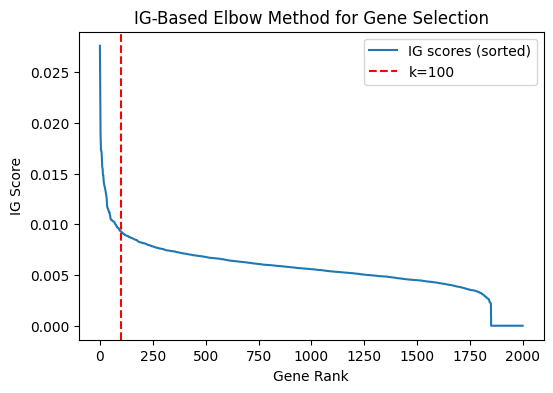

---- Final Cross-Validation on IG-Selected Genes ----
Fold Done (acc=0.542,spec={0: 0.9333333333333333, 1: 0.375, 2: 1.0},sens={0: 0.4444444444444444, 1: 1.0, 2: 0.14285714285714285},mean_sens=0.529, mean_spec=0.769)
Fold Done (acc=0.304,spec={0: 0.6363636363636364, 1: 0.4375, 2: 0.8421052631578947},sens={0: 0.4166666666666667, 1: 0.0, 2: 0.5},mean_sens=0.306, mean_spec=0.639)
Fold Done (acc=0.261,spec={0: 0.46153846153846156, 1: 0.5333333333333333, 2: 0.8333333333333334},sens={0: 0.5, 1: 0.125, 2: 0.0},mean_sens=0.208, mean_spec=0.609)
Fold Done (acc=0.522,spec={0: 0.5384615384615384, 1: 0.75, 2: 0.9411764705882353},sens={0: 0.9, 1: 0.42857142857142855, 2: 0.0},mean_sens=0.443, mean_spec=0.743)
Fold Done (acc=0.478,spec={0: 0.5333333333333333, 1: 0.6428571428571429, 2: 1.0},sens={0: 0.625, 1: 0.4444444444444444, 2: 0.3333333333333333},mean_sens=0.468, mean_spec=0.725)

=== Cross-Validation Summary (5-fold) ===
Mean Val Acc: 0.4214
Mean Loss: 1.6645
Mean Sensitivity: 0.3907
Mean Specif

In [213]:
train_data = pd.read_csv('train_mi_data.csv', index_col=None)

# Separate features (genes) and labels
X_df = train_data.drop(columns=['sample', 'disease_state'])

label_map = {
    'S-MCI': 1,
    'P-MCI': 2,
    'AD': 0
}

y = train_data['disease_state']
y_int = y.replace(label_map).astype(int).values   # numpy array
X_np_raw = X_df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np_raw)         # already numpy
print(f"Training data shape: {X_scaled.shape}, Labels shape: {y_int.shape}")
X_np = X_scaled.astype(np.float32)     # safe conversion
y_np = y_int.astype(np.int64)
print(f"Classify:  {np.unique(y_np, return_counts=True)} clases")

# Step 1 — CV to train multiple CNNs
fold_models = cross_validate_cnn(X_np, y_np, k_folds=5, epochs=50)

# Step 2 — Compute global IG scores
ig_scores = compute_global_ig(fold_models, X_np, y_np)

# Step 3 — Automatic optimal k using IG-elbow
k_opt = find_optimal_k(ig_scores)

# Step 4 — Reduce dataset to top-k genes
X_reduced, selected_idx = reduce_genes(X_np, ig_scores, 100)

# Step 5 — Train final CNN on IG-selected genes
final_model_task2 = train_final_cnn_cv(X_reduced, y_np, epochs=50)


In [218]:
ad_spec = np.mean([0.9333333333333333, 0.6363636363636364, 0.46153846153846156, 0.5384615384615384, 0.5333333333333333])
print("AD spec:", ad_spec)
smci_spec =  np.mean([0.375, 0.4375, 0.5333333333333333,0.75, 0.6428571428571429 ])
print("SMCI spec:", smci_spec)
pmci_spec =  np.mean([1.0, 0.8421052631578947, 0.8333333333333334, 0.9411764705882353, 1.0])
print("PMCI spec:", pmci_spec)

ad_sen =  np.mean([0.4444444444444444,0.4166666666666667, 0.5, 0.9, 0.625])
print("AD sen:", ad_sen)
smci_sen =  np.mean([1.0,0.0, 0.125,  0.42857142857142855, 0.4444444444444444])
print("SMCI sen:", smci_sen)
pmci_sen =  np.mean([0.14285714285714285,0.5, 0.0,  0.0, 0.3333333333333333])
print("PMCI sen:",pmci_sen)

AD spec: 0.6206060606060606
SMCI spec: 0.5477380952380952
PMCI spec: 0.9233230134158926
AD sen: 0.5772222222222222
SMCI sen: 0.3996031746031746
PMCI sen: 0.1952380952380952


In [214]:
gene_cols = X_df.columns.tolist()

top_genes = [gene_cols[i] for i in selected_idx]
print(f"Top IG-selected genes: {len(top_genes)} \n {top_genes}")
sorted_ig = np.sort(ig_scores[selected_idx])[::-1]
top_k_task2 = pd.DataFrame({'gene_id': top_genes, 'ig_score': sorted_ig[:200]})

top_k_task2.to_csv('top_ig_genes_task2.csv', index=False)

Top IG-selected genes: 100 
 ['ENSG00000229637', 'ENSG00000284631', 'ENSG00000259303', 'ENSG00000161849', 'ENSG00000179546', 'ENSG00000166840', 'ENSG00000186340', 'ENSG00000214026', 'ENSG00000074416', 'ENSG00000094661', 'ENSG00000169429', 'ENSG00000166363', 'ENSG00000101680', 'ENSG00000283496', 'ENSG00000094963', 'ENSG00000002746', 'ENSG00000164107', 'ENSG00000174442', 'ENSG00000162365', 'ENSG00000113100', 'ENSG00000189171', 'ENSG00000121207', 'ENSG00000211967', 'ENSG00000277150', 'ENSG00000167264', 'ENSG00000113739', 'ENSG00000147649', 'ENSG00000146453', 'ENSG00000182256', 'ENSG00000183054', 'ENSG00000176988', 'ENSG00000196620', 'ENSG00000242498', 'ENSG00000244122', 'ENSG00000160813', 'ENSG00000161798', 'ENSG00000137090', 'ENSG00000165175', 'ENSG00000160213', 'ENSG00000242114', 'ENSG00000197548', 'ENSG00000005421', 'ENSG00000185220', 'ENSG00000183778', 'ENSG00000280416', 'ENSG00000175619', 'ENSG00000107159', 'ENSG00000244731', 'ENSG00000102055', 'ENSG00000100625', 'ENSG00000124215', '

### Evaluation

In [215]:
from sklearn.metrics import confusion_matrix, accuracy_score

def test_cnn(model, test_loader, device, positive_class=1):
    """
    Evaluates a trained CNN model on test data.

    Args:
        model: trained PyTorch model
        test_loader: DataLoader for test dataset
        device: 'cuda' or 'cpu'
        positive_class: int, class for sensitivity/specificity

    Returns:
        metrics: dict with accuracy, sensitivity, specificity, confusion matrix
        y_true: true labels (numpy)
        y_pred: predicted labels (numpy)
    """
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            logits = model(xb)
            preds = torch.argmax(logits, dim=1)

            y_true.extend(yb.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    print(f"Raw predicted labels: {np.unique(y_pred, return_counts=True)}")
    label_map = {
        1:1,
        2:1,
        0:0
    }
    y_pred = np.array([label_map[label] for label in y_pred])
    print(f"Prediction class: {np.unique(y_pred, return_counts=True)}")

    # Accuracy
    acc = accuracy_score(y_true, y_pred)

    # Sensitivity & Specificity for the selected class
    pos_mask = (y_true == positive_class)
    pred_pos_mask = (y_pred == positive_class)

    TP = np.sum(pos_mask & pred_pos_mask)
    FN = np.sum(pos_mask & (~pred_pos_mask))
    TN = np.sum((~pos_mask) & (~pred_pos_mask))
    FP = np.sum((~pos_mask) & pred_pos_mask)

    sensitivity = TP / (TP + FN + 1e-8)
    specificity = TN / (TN + FP + 1e-8)

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    metrics = {
        "accuracy": acc,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "confusion_matrix": cm
    }

    return metrics, y_true, y_pred


Test data shape: (41, 100), Labels shape: (41,)
Raw predicted labels: (array([0, 1, 2]), array([21, 19,  1]))
Prediction class: (array([0, 1]), array([21, 20]))
Test Accuracy: 0.36585365853658536
Sensitivity: 0.0
Specificity: 0.9999999997560975
Confusion Matrix:
 [[ 8 13]
 [13  7]]


/var/folders/5t/qhv6pkk115b3_mpr1bbc5c9c0000gn/T/ipykernel_65674/2355848397.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_int = y.replace(label_map).astype(int).values   # numpy array


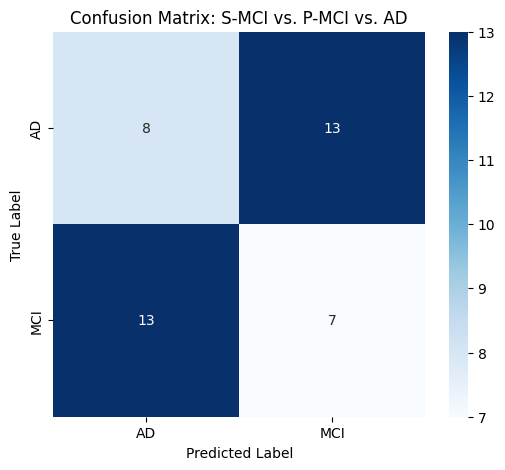

In [216]:
test_data = pd.read_csv('test_mi_data.csv', index_col=None)
X_df = test_data.drop(columns=['sample', 'disease_state'])
X_df = X_df[top_genes]  # select only IG-chosen genes
label_map = {
    'MCI':1,
    'AD': 0
}
y = test_data['disease_state']
y_int = y.replace(label_map).astype(int).values   # numpy array

X_np_raw = X_df.values.astype(np.float32)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_np_raw)         # already numpy
print(f"Test data shape: {X_scaled.shape}, Labels shape: {y_int.shape}")
X_test_np = X_scaled.astype(np.float32)     # safe conversion
y_test_np = y_int.astype(np.int64)


# Assuming X_test_np, y_test_np are NumPy arrays
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test_np, dtype=torch.long)

test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Load best model
model = final_model_task2[0]
# model = CNN_1D(num_classes=len(np.unique(y_test_np)))
# model.load_state_dict(torch.load("best_model.pth"))
model.to(device)

metrics, y_true, y_pred = test_cnn(model, test_loader, device, positive_class=2)

print("Test Accuracy:", metrics["accuracy"])
print("Sensitivity:", metrics["sensitivity"])
print("Specificity:", metrics["specificity"])
print("Confusion Matrix:\n", metrics["confusion_matrix"])

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(metrics["confusion_matrix"], annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"AD", f"MCI"],
            yticklabels=[f"AD", f"MCI"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix: S-MCI vs. P-MCI vs. AD')
plt.show()

## Compare genes

In [4]:
# task 1
gene_names = pd.read_csv('gene_id_and_gene_symbols.csv')
ig_output = pd.read_csv('top_ig_genes_task1.csv')
merged = pd.merge(ig_output, gene_names, on='gene_id', how='left')
print(merged.head())

ranked_df = pd.DataFrame({
    "gene": merged['gene_symbol'],
    "score": merged['ig_score']
})
ranked_df = ranked_df.sort_values("score", ascending=False)
ranked_df.to_csv("cnn_ranked_task1.rnk", sep="\t", header=False, index=False)

# task 2
ig_output = pd.read_csv('top_ig_genes_task2.csv')
merged = pd.merge(ig_output, gene_names, on='gene_id', how='left')
print(merged.head())

ranked_df = pd.DataFrame({
    "gene": merged['gene_symbol'],
    "score": merged['ig_score']
})
ranked_df = ranked_df.sort_values("score", ascending=False)
ranked_df.to_csv("cnn_ranked_task2.rnk", sep="\t", header=False, index=False)

           gene_id  ig_score           gene_symbol
0  ENSG00000284631  0.021707                SCYGR4
1  ENSG00000179546  0.019861                 HTR1D
2  ENSG00000279076  0.019670  gene:ENSG00000279076
3  ENSG00000183067  0.018165                 IGSF5
4  ENSG00000214026  0.017828                MRPL23
           gene_id  ig_score  gene_symbol
0  ENSG00000229637  0.027601        PRAC2
1  ENSG00000284631  0.024677       SCYGR4
2  ENSG00000259303  0.020664  IGHV2OR16-5
3  ENSG00000161849  0.018901        KRT84
4  ENSG00000179546  0.018049        HTR1D


### GSEA

2025-12-08 13:46:53,513 [WARNING] Duplicated values found in preranked stats: 1.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.
2025-12-08 13:46:53,514 [INFO] Parsing data files for GSEA.............................
2025-12-08 13:46:53,514 [INFO] Enrichr library gene sets already downloaded in: /Users/kitiya/.cache/gseapy, use local file
2025-12-08 13:46:53,525 [INFO] 0260 gene_sets have been filtered out when max_size=100 and min_size=2
2025-12-08 13:46:53,526 [INFO] 0060 gene_sets used for further statistical testing.....
2025-12-08 13:46:53,526 [INFO] Start to run GSEA...Might take a while..................
2025-12-08 13:46:53,554 [INFO] Congratulations. GSEApy runs successfully................



,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,prerank,Malaria,0.908163,1.570216,0.025597,1.0,0.428,2/2,11.00%,THBS2;CXCL8
1,prerank,Natural killer cell mediated cytotoxicity,-0.785714,-1.405115,0.111111,1.0,0.745,2/2,24.00%,MICA;ARAF
2,prerank,Retinol metabolism,0.680412,1.39425,0.110924,1.0,0.791,3/3,34.00%,LRAT;UGT2B15;UGT1A7
3,prerank,Drug metabolism,0.680412,1.390799,0.093537,1.0,0.797,3/3,34.00%,FMO2;UGT2B15;UGT1A7
4,prerank,Insulin signaling pathway,-0.755102,-1.387507,0.119101,0.741889,0.765,2/2,27.00%,ARAF;PCK1


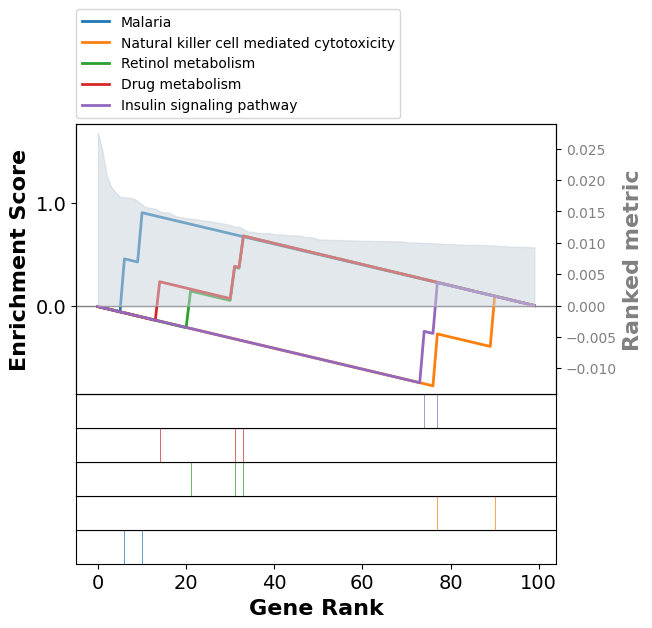

In [8]:
import gseapy as gp

# Run prerank GSEA
pre_res = gp.prerank(
    rnk="cnn_ranked_task2.rnk",
    gene_sets='KEGG_2021_Human', 
    outdir='gsea_results',
    min_size=2,
    max_size=100,
    permutation_num=1000,
    seed=6,
    verbose=True
)

# Display top enriched pathways
display(pre_res.res2d.head(5))

# Plot GSEA enrichment for top pathway
terms = pre_res.res2d.Term
axs = pre_res.plot(terms=terms[0:5],
                #    legend_kws={'loc': (1.2, 0)}, # set the legend loc
                   show_ranking=True, # whether to show the second yaxis
                   figsize=(3,4)
                  )